In [1]:
__author__ = "Thomas McClave"
# Uses Atchar Sudhyadhom's paper.

import json
import numpy as np
import matplotlib.pyplot as plt

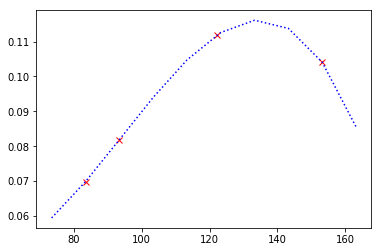

In [8]:
with open('dixon/dixon-results.json','r') as dixRes:
    dix_res = json.loads(dixRes.read())
    
with open('zte/zte-results.json','r') as zteRes:
    zte_res = json.loads(zteRes.read())
    
with open('ct/ct-results.json','r') as ctRes:
    ct_res = json.loads(ctRes.read())


# Create ZTE calibration curve that uses (Signal_zte)/(physical density):
calibration_containers = ["W01.1", "A02.1", "A03.1", "A04.1"]
pd_over_rhoPhysical = np.array([])
for roi in zte_res:
    for cc in calibration_containers:
        if (cc in roi):
            pd = zte_res[roi]['data']['ZTE Mean Signal']
            rhoPhysical = ct_res[roi]['data']['CT fit physical density']
            pd_over_rhoPhysical = np.append(pd_over_rhoPhysical, float(pd/rhoPhysical))
            
H_refs = np.array([
    0.081688083, # Acetone (A02.1)
    0.104127575, # Isopropyl Alcohol (A03.1)
    0.069864914, # Propargyl Alcohol (A04.1)
    0.111898344, # Water (W01.1)
])

fit = np.polyfit(pd_over_rhoPhysical, H_refs, 1)
fit_fn = np.poly1d(fit)

plt.plot(pd_over_rhoPhysical, H_refs, 'rx', label='calibration points')
pdw_sig = np.linspace(min(pd_over_rhoPhysical)-10, max(pd_over_rhoPhysical)+10, 10)
plt.plot(pdw_sig, fit_fn(pdw_sig), 'b:', label='fit')

plt.show()

In [3]:
def SPR(pe_water, I_m, I_water):
    # Returns proton stopping power ratio assuming zero bone (exclusively tissue).
    # Input: pe_water: Electron density normalized to water (from CT).
    #        I_m: use calc_I_m() function below.
    #        beta: proton velocity relative to c.
    
    beta = 0.454363  # Proton w/ 115 MeV kinetic energy:
    e_m_E = 510998.9  # Electron rest mass energy (mc^2) in eV.
    numerator = np.log( (2*e_m_E*beta**2) / (I_m*(1-beta**2)) ) - beta**2
    denominator = np.log( (2*e_m_E*beta**2) / (I_water*(1-beta**2)) ) - beta**2
    SPR = float(pe_water*numerator/denominator)
    return SPR

def calc_I_m(w_H20, I_water, h_org_vox):
    # Returns I_m (ionization potential for given material).
    # Input: w_H20: derived from DIXON data.
    #        I_water: derived from DIXON OR chemical composition.
    #        h_org_vox: use calc_h_org_vox() function defined below.
    
    A = 93.23 # eV
    B = -3.47 # eV
    I_m_log = w_H20*np.log(I_water) + (1-w_H20)*(np.log(A) + B*h_org_vox)
    return np.exp(I_m_log)

def calc_h_org_vox(h_tot, w_H20):
    # Returns h_org_vox (actually per ROI, currently).
    # Input: h_tot: from CT and ZTE.
    #        h_H20: from CT and ZTE for water reference.
    #        w_H20: derived from DIXON data.
    
    h_H20 = .112
    return (h_tot - w_H20*h_H20) / (1 - w_H20)

def calc_h_tot(roi):
    # Returns h_tot for this particular roi
    pd = zte_res[roi]['data']['ZTE Mean Signal']
    rhoPhysical = ct_res[roi]['data']['CT fit physical density']
    return fit_fn(pd / rhoPhysical)

In [4]:
# UCSF Stoichiometric Calibration Curve data:
HU_refs_below = np.array([-1000, -200, -120, -20])
HU_refs_above = np.array([35, 100, 140, 4500])

psrel_refs_below = np.array([0.0, 0.7985, 0.9476, 1.0125])
psrel_refs_above = np.array([1.0330, 1.0979, 1.0964, 3.1221])

fit_stoich_below = np.polyfit(HU_refs_below, psrel_refs_below, 1)
fit_fn_stoich_below = np.poly1d(fit_stoich_below)

fit_stoich_above = np.polyfit(HU_refs_above, psrel_refs_above, 1)
fit_fn_stoich_above = np.poly1d(fit_stoich_above)

In [5]:
import json
import re
from copy import copy

cid_re = re.compile('[A-Z][0-9]{2}\.?[0-9]?')
results = {}

HU_vals = []
spr_vals = []
spr_HU_and_label = []
pe_water_all = []
I_m_vals = {}

for roi in dix_res:
    if ('B' not in roi): # We're not considering any bone this time!
        h_tot = calc_h_tot(roi)
        w_H20 = dix_res[roi]['data']['Dixon Water Signal'] / dix_res['W01.1']['data']['Dixon Water Signal']        
        rhoPhysical = ct_res[roi]['data']['CT fit physical density']
        h_org_vox = calc_h_org_vox(h_tot, w_H20)
        I_water = 75.3 # (eV), from chemical composition!
        pe_water = ct_res[roi]['data']['CT fit relative electron density']
        pe_water_all += [pe_water]
        I_m = calc_I_m(w_H20, I_water, h_org_vox)
        I_m_vals[roi] = I_m
        SPR_val_chemcomp = SPR(pe_water, I_m, I_water)
        
        HU_vals += [ct_res[roi]['data']['CT Mean HU value']]
        spr_vals += [SPR_val_chemcomp]
        spr_HU_and_label += [(SPR_val_chemcomp, ct_res[roi]['data']['CT Mean HU value'], dix_res[roi]['label'])]
        
        cid = cid_re.search(dix_res[roi]['label']).group()
        results[cid] = {
            'label' : dix_res[roi]['label'],
            'data' : {
                'SPR w/ I_H20 from chemical composition' : SPR_val_chemcomp
            }
        }
pe_water_all = np.array(pe_water_all)

    
# Write in chemical composition values:
SPR_chem_comp_HU = np.zeros(len(spr_HU_and_label))
SPR_chem_comp = np.zeros(len(spr_HU_and_label))
I_isopropyl_alcohol=62.8803
pe_water_isoprop=0.818858
SPR_chem_comp_HU[1] = ct_res['A03.1']['data']['CT Mean HU value']
SPR_chem_comp[1] = SPR(pe_water_isoprop, I_isopropyl_alcohol, I_water) # Isopropyl Alcohol

I_acetone=66.1406
pe_water_acetone=0.77818
SPR_chem_comp_HU[0] = ct_res['A02.1']['data']['CT Mean HU value']
SPR_chem_comp[0] = SPR(pe_water_acetone, I_acetone, I_water) # Acetone

SPR_pe_contribution = list(SPR_chem_comp[:2]) + [0]
SPR_Im_contribution = list(SPR_chem_comp[:2]) + [0]

# Calculation for liver:
curr_liver_index = 3
pe_liver = [0,0,0]
pe_liver_from_ct = [0,0,0]
for roi in dix_res:
    if ("N0" in roi or "I0" in roi or "L0" in roi):
        p_m_liver = ct_res[roi]['data']['CT fit physical density']
        pe_water_liver_from_ct = ct_res[roi]['data']['CT fit relative electron density']
        pe_liver_from_ct += [pe_water_liver_from_ct]
        pe_water_liver = p_m_liver*0.548778005/(10/18.0152)
        pe_liver += [pe_water_liver]
        I_liver=74.49449405
        SPR_liver_true=SPR(pe_water_liver, I_liver, I_water)
        SPR_pe_contribution += [SPR(pe_water_liver_from_ct, I_liver, I_water)]
        SPR_Im_contribution += [SPR(pe_water_liver, I_m_vals[roi], I_water)]
        SPR_chem_comp[curr_liver_index] = SPR_liver_true
        SPR_chem_comp_HU[curr_liver_index] = ct_res[roi]['data']['CT Mean HU value']
        curr_liver_index += 1


pe_liver += [0]
pe_liver_from_ct += [0]
SPR_pe_contribution += [0]
pe_liver = np.array(pe_liver)
pe_liver_from_ct = np.array(pe_liver_from_ct)
# print('pe_liver', 'pe_liver_from_ct')
# print(pe_liver, '\n', pe_liver_from_ct)


print('SPR (CHEM): ', '\t|%err (PE Contribution):', '|%err (Im Contribution):', '| Label:')
for i in range(3,len(spr_HU_and_label)-1):
    SPR_CHEM = SPR_chem_comp[i]
    SPR_PE = SPR_pe_contribution[i]
    SPR_Im = SPR_Im_contribution[i]
    PE_err = format( 100*abs(SPR_CHEM - SPR_PE) / (0.5*(SPR_CHEM + SPR_PE)) , '.6f')
    Im_err = format( 100*abs(SPR_CHEM - SPR_Im) / (0.5*(SPR_CHEM + SPR_Im)) , '.6f')
    label = spr_HU_and_label[i][2]
    
    SPR_CHEM_STR = format(SPR_CHEM, '.6f')
    print('', SPR_CHEM_STR, '\t|', PE_err, '\t|', Im_err, '\t|', label)


error = []
for i in range(len(spr_HU_and_label)):
    error += [100*abs(spr_HU_and_label[i][0] - SPR_chem_comp[i]) / (0.5*(spr_HU_and_label[i][0] + SPR_chem_comp[i]))]
# print(error)

# print('I_liver_UC', calc_I_m(0.6859949928,I_water,0.071375))

with open('spr-results.json','w') as jout:
    jout.write(json.dumps(results, indent=4, sort_keys=True))

SPR (CHEM):  	|%err (PE Contribution): |%err (Im Contribution): | Label:
 1.066710 	| 2.983743 	| 0.166314 	| 12: (I01.1) (I1) Intact Liver (Relative), prep: cut and "stuff"
 1.063609 	| 3.015900 	| 0.129468 	| 17: (I01.2) (I2) Intact Liver (Relative), prep: cut and "stuff"
 1.067074 	| 2.979985 	| 0.166217 	| 10: (I01.3) (I3) Intact Liver (Relative), prep: cut and "stuff"
 0.976835 	| 4.576779 	| 0.363376 	| 16: (L01.1) (LS1(A)) Liver Stability, in Air
 0.990051 	| 4.579218 	| 0.313700 	| 9: (L01.2) (LS2(B)) Liver Stability, Vacuum
 1.064055 	| 3.011272 	| 0.085896 	| 11: (L01.3) (LS3(C)) Liver Stability, Fridge
 1.058562 	| 3.068629 	| 0.027277 	| 13: (L01.4) (LS4(D)) Liver Stability, Freezer
 1.074312 	| 2.905643 	| 0.201651 	| 4: (N01.1) (N1) Liver (ground) in 20mL container
 1.067020 	| 2.980535 	| 0.130442 	| 18: (N01.2) (N2) Liver (ground) in 20mL container
 1.070108 	| 2.948711 	| 0.104744 	| 6: (N01.3) (N3) Liver (ground) in 20mL container


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 1080x360 with 0 Axes>

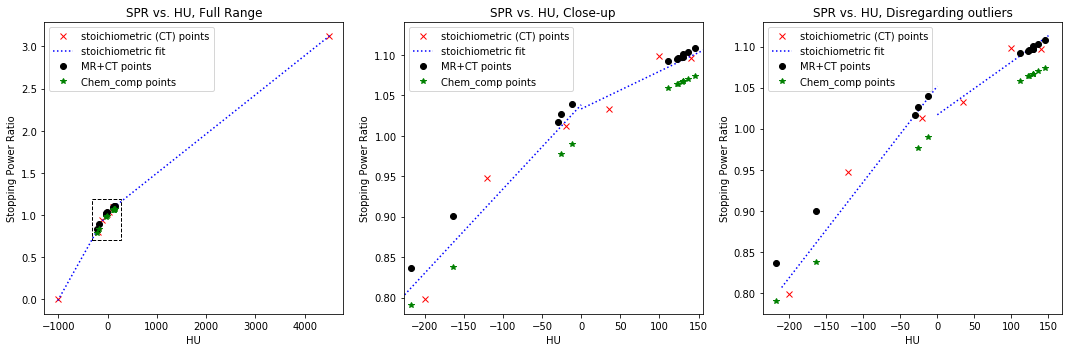

In [6]:
plt.figure(figsize=(15.0, 5.0))
fig, ax = plt.subplots(1, 3, figsize=(15.0, 5.0))

SPR_chem_comp_plot = copy(SPR_chem_comp)
SPR_chem_comp_HU_plot = copy(SPR_chem_comp_HU)

for j in range(len(SPR_chem_comp_plot)-1, -1, -1):
    if (SPR_chem_comp_plot[j] < 0.001):
        SPR_chem_comp_plot = np.delete(SPR_chem_comp_plot, j)
        SPR_chem_comp_HU_plot = np.delete(SPR_chem_comp_HU_plot, j)
        
# Plot full range:
ai = ax[0]
ai.plot(HU_refs_below, psrel_refs_below, 'rx', label='stoichiometric (CT) points')
ai.plot(HU_refs_above, psrel_refs_above, 'rx')

HU_sig_below = np.linspace(min(HU_refs_below)-10, 0, 10)
ai.plot(HU_sig_below, fit_fn_stoich_below(HU_sig_below), 'b:', label='stoichiometric fit')
HU_sig_above = np.linspace(0, max(HU_refs_above)+10, 10)
ai.plot(HU_sig_above, fit_fn_stoich_above(HU_sig_above), 'b:')

ai.plot(HU_vals, spr_vals, 'ko', label='MR+CT points')
ai.plot(SPR_chem_comp_HU_plot, SPR_chem_comp_plot, 'g*', label='Chem_comp points')

ai.set_title('SPR vs. HU, Full Range')
ai.set_xlabel('HU')
ai.set_ylabel('Stopping Power Ratio')
rect = plt.Rectangle( (min(HU_vals)-100, 0.70) , max(HU_vals)+10 - min(HU_vals)+210 , 1.14-0.65, fill=False, linestyle = 'dashed')
ai.add_patch(rect)
ai.legend()


# Plot close-up of range:
ai = ax[1]

ai.plot(HU_refs_below, psrel_refs_below, 'rx', label='stoichiometric (CT) points')
ai.plot(HU_refs_above, psrel_refs_above, 'rx')

HU_sig_below = np.linspace(min(HU_refs_below)-10, 0, 10)
ai.plot(HU_sig_below, fit_fn_stoich_below(HU_sig_below), 'b:', label='stoichiometric fit')
HU_sig_above = np.linspace(0, max(HU_refs_above)+10, 10)
ai.plot(HU_sig_above, fit_fn_stoich_above(HU_sig_above), 'b:')

ai.plot(HU_vals, spr_vals, 'ko', label='MR+CT points')
ai.plot(SPR_chem_comp_HU_plot, SPR_chem_comp_plot, 'g*', label='Chem_comp points')
ai.set_title('SPR vs. HU, Close-up')
ai.set_xlabel('HU')
ai.set_ylabel('Stopping Power Ratio')
ai.set_xlim(min(HU_vals)-10, max(HU_vals)+10)
ai.set_ylim(0.78, 1.14)
ai.legend()


# Plot without outliers:
HU_refs_stripped_below = [ref for ref in HU_refs_below if (ref > -300 and ref < 4400)]
HU_refs_stripped_above = [ref for ref in HU_refs_above if (ref > -300 and ref < 4400)]

psrel_refs_stripped_below = [ref for ref in psrel_refs_below if (ref > 0.5 and ref < 3)]
psrel_refs_stripped_above = [ref for ref in psrel_refs_above if (ref > 0.5 and ref < 3)]

fit_stoich_limited_below = np.polyfit(HU_refs_stripped_below, psrel_refs_stripped_below, 1)
fit_fn_stoich_limited_below = np.poly1d(fit_stoich_limited_below)
fit_stoich_limited_above = np.polyfit(HU_refs_stripped_above, psrel_refs_stripped_above, 1)
fit_fn_stoich_limited_above = np.poly1d(fit_stoich_limited_above)

ai = ax[2]
ai.plot(HU_refs_stripped_below, psrel_refs_stripped_below, 'rx', label='stoichiometric (CT) points')
ai.plot(HU_refs_stripped_above, psrel_refs_stripped_above, 'rx')

HU_sig_below = np.linspace(min(HU_refs_stripped_below)-10, 0, 10)
ai.plot(HU_sig_below, fit_fn_stoich_limited_below(HU_sig_below), 'b:', label='stoichiometric fit')
HU_sig_above = np.linspace(0, max(HU_refs_stripped_above)+10, 10)
ai.plot(HU_sig_above, fit_fn_stoich_limited_above(HU_sig_above), 'b:')

ai.plot(HU_vals, spr_vals, 'ko', label='MR+CT points')
ai.plot(SPR_chem_comp_HU_plot, SPR_chem_comp_plot, 'g*', label='Chem_comp points')
ai.set_title('SPR vs. HU, Disregarding outliers')
ai.set_xlabel('HU')
ai.set_ylabel('Stopping Power Ratio')
ai.legend()


fig.tight_layout()
fig.patch.set_facecolor('#ffffff')
plt.show()

fig.savefig('SPR_vs_HU.png')

In [7]:
# Create output Table:

spr_vals_below = np.array([])
HU_vals_below = np.array([])
spr_vals_above = np.array([])
HU_vals_above = np.array([])

for i in range(len(HU_vals)):
    if (HU_vals[i] < 0):
        spr_vals_below = np.append(spr_vals_below, spr_vals[i])
        HU_vals_below = np.append(HU_vals_below, HU_vals[i])
    else:
        spr_vals_above = np.append(spr_vals_above, spr_vals[i])
        HU_vals_above = np.append(HU_vals_above, HU_vals[i])


print('SPR (MR+CT): ', '\t| SPR (CT): ', '\t| SPR (CHEM): ', '\t| Label:')
for i in range(len(spr_HU_and_label)-1):
    SPR_MRCT = round(spr_HU_and_label[i][0], 6)
    SPR_CHEM = format(SPR_chem_comp[i], '.6f')
    label = spr_HU_and_label[i][2]
    if (spr_HU_and_label[i][1] < 0):
        SPR_CT = round(fit_fn_stoich_below(spr_HU_and_label[i][1]), 6)
    else:
        SPR_CT = round(fit_fn_stoich_above(spr_HU_and_label[i][1]), 6)
    print('', SPR_MRCT, '\t| ', SPR_CT, '\t| ', SPR_CHEM, '\t| ', label)

SPR (MR+CT):  	| SPR (CT):  	| SPR (CHEM):  	| Label:
 0.836165 	|  0.812437 	|  0.790855 	|  7: (A02.1) (A1) Acetone
 0.900375 	|  0.86732 	|  0.837394 	|  1: (A03.1) (IA1) Isopropyl Alcohol
 1.016854 	|  1.007164 	|  0.000000 	|  8: (A04.1) (PA1) Propargyl Alcohol
 1.097194 	|  1.09301 	|  1.066710 	|  12: (I01.1) (I1) Intact Liver (Relative), prep: cut and "stuff"
 1.09476 	|  1.08991 	|  1.063609 	|  17: (I01.2) (I2) Intact Liver (Relative), prep: cut and "stuff"
 1.097527 	|  1.093374 	|  1.067074 	|  10: (I01.3) (I3) Intact Liver (Relative), prep: cut and "stuff"
 1.026312 	|  1.011409 	|  0.976835 	|  16: (L01.1) (LS1(A)) Liver Stability, in Air
 1.039706 	|  1.025743 	|  0.990051 	|  9: (L01.2) (LS2(B)) Liver Stability, Vacuum
 1.095645 	|  1.090355 	|  1.064055 	|  11: (L01.3) (LS3(C)) Liver Stability, Fridge
 1.091849 	|  1.084862 	|  1.058562 	|  13: (L01.4) (LS4(D)) Liver Stability, Freezer
 1.108221 	|  1.100613 	|  1.074312 	|  4: (N01.1) (N1) Liver (ground) in 20mL conta

w/ 120 kVp:
SPR (MR+CT):  	| SPR (CT):  	| SPR (CHEM):  	| Label:
 0.836165 	|  0.812437 	|  0.790855 	|  7: (A02.1) (A1) Acetone
 0.900375 	|  0.86732 	|  0.837394 	|  1: (A03.1) (IA1) Isopropyl Alcohol
 1.016854 	|  1.007164 	|  0.000000 	|  8: (A04.1) (PA1) Propargyl Alcohol
 1.097194 	|  1.09301 	|  1.066710 	|  12: (I01.1) (I1) Intact Liver (Relative), prep: cut and "stuff"
 1.09476 	|  1.08991 	|  1.063609 	|  17: (I01.2) (I2) Intact Liver (Relative), prep: cut and "stuff"
 1.097527 	|  1.093374 	|  1.067074 	|  10: (I01.3) (I3) Intact Liver (Relative), prep: cut and "stuff"
 1.026312 	|  1.011409 	|  0.976835 	|  16: (L01.1) (LS1(A)) Liver Stability, in Air
 1.039706 	|  1.025743 	|  0.990051 	|  9: (L01.2) (LS2(B)) Liver Stability, Vacuum
 1.095645 	|  1.090355 	|  1.064055 	|  11: (L01.3) (LS3(C)) Liver Stability, Fridge
 1.091849 	|  1.084862 	|  1.058562 	|  13: (L01.4) (LS4(D)) Liver Stability, Freezer
 1.108221 	|  1.100613 	|  1.074312 	|  4: (N01.1) (N1) Liver (ground) in 20mL container
 1.100739 	|  1.093321 	|  1.067020 	|  18: (N01.2) (N2) Liver (ground) in 20mL container
 1.103289 	|  1.096408 	|  1.070108 	|  6: (N01.3) (N3) Liver (ground) in 20mL container
 
pe_liver pe_liver_from_ct
[0.         0.         0.         1.06527145 1.06217484 1.06563438
 0.97551694 0.98871545 1.06261949 1.05713391 1.07286345 1.06558129
 1.06866426 0.        ] 
 [0.         0.         0.         1.09753778 1.09469943 1.09787044
 1.02120982 1.03505181 1.095107   1.09007891 1.10449661 1.09782178
 1.10064763 0.        ]
 
 
 w/ 140 kVp: